In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

np.random.seed(101)

# List of file paths
file_paths = ['Inflow_Outflow-Table 1.csv', 'Products_ActBalance-Table 1.csv', 'Soc_Dem-Table 1.csv', 'Sales_Revenues-Table 1.csv']

# Initialize an empty list to store DataFrames
dfs = []

# Read each file into a DataFrame and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Perform an inner join on the 'Client' column for all DataFrames
merged_df = dfs[0]  # Start with the first DataFrame
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='Client', how='inner')

df = merged_df

In [2]:
df = df.drop(columns=['Count_CA','VolumeCred_CA','TransactionsCred_CA','VolumeDeb_CA','TransactionsDeb_CA','VolumeDeb','Revenue_MF', 'Revenue_CC', 'Revenue_CL','Client','Count_SA','Count_MF','Count_OVD','Count_CC','Count_CL','ActBal_SA','ActBal_MF','ActBal_OVD','ActBal_CC','ActBal_CL','Unnamed: 4'])
df_cleaned = df.dropna()
df = df_cleaned

df['Sale_MF'] = df['Sale_MF'].map({1: 'yes', 0: 'no'})
df['Sale_CC'] = df['Sale_CC'].map({1: 'yes', 0: 'no'})
df['Sale_CL'] = df['Sale_CL'].map({1: 'yes', 0: 'no'})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, 0 to 950
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VolumeCred                    949 non-null    float64
 1   TransactionsCred              949 non-null    int64  
 2   VolumeDebCash_Card            949 non-null    float64
 3   VolumeDebCashless_Card        949 non-null    float64
 4   VolumeDeb_PaymentOrder        949 non-null    float64
 5   TransactionsDeb               949 non-null    int64  
 6   TransactionsDebCash_Card      949 non-null    int64  
 7   TransactionsDebCashless_Card  949 non-null    int64  
 8   TransactionsDeb_PaymentOrder  949 non-null    int64  
 9   ActBal_CA                     949 non-null    float64
 10  Sex                           949 non-null    object 
 11  Age                           949 non-null    int64  
 12  Tenure                        949 non-null    int64  
 13  Sale_MF   

In [4]:
!pip install mesa


          VolumeCred  TransactionsCred  VolumeDebCash_Card  \
count     949.000000        949.000000          949.000000   
mean     1833.102737          5.654373          271.088057   
std      6218.049899          6.411573          874.505249   
min         0.000000          0.000000            0.000000   
25%       269.107857          2.000000            0.000000   
50%       657.161429          4.000000           89.285714   
75%      1449.070714          6.000000          357.142857   
max    107703.804286         63.000000        23571.428571   

       VolumeDebCashless_Card  VolumeDeb_PaymentOrder  TransactionsDeb  \
count              949.000000              949.000000       949.000000   
mean               157.251256              718.876966        16.357218   
std                333.302042             3101.157753        16.383649   
min                  0.000000                0.000000         0.000000   
25%                  0.000000                0.000000         4.000000 

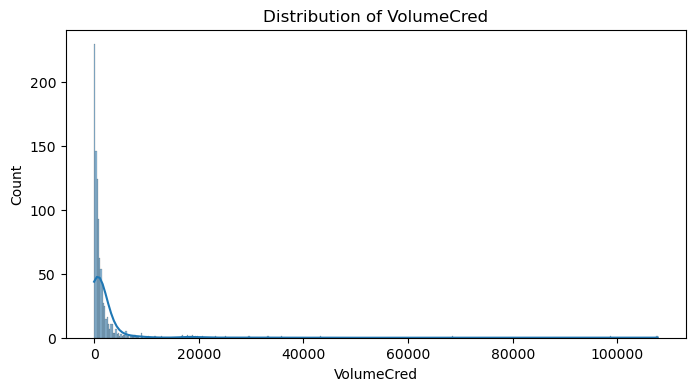

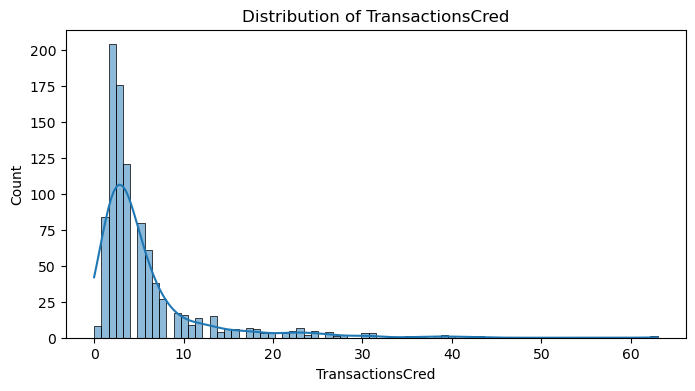

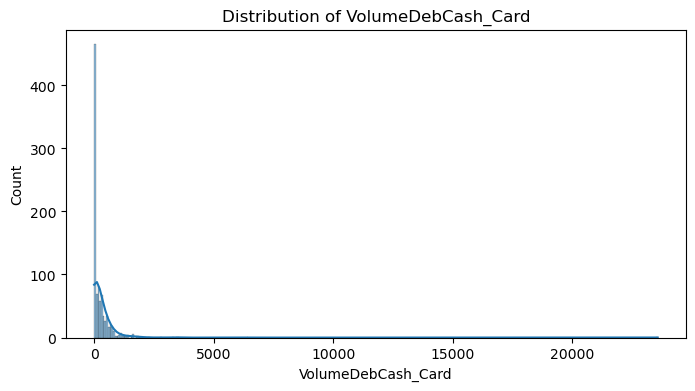

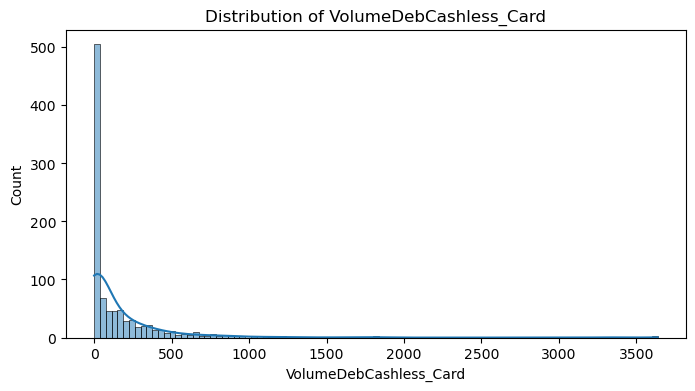

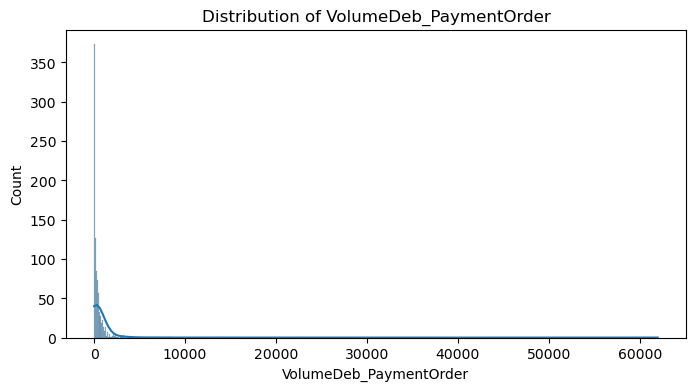

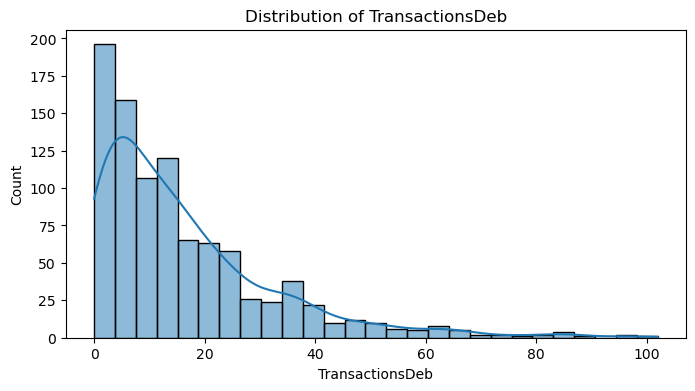

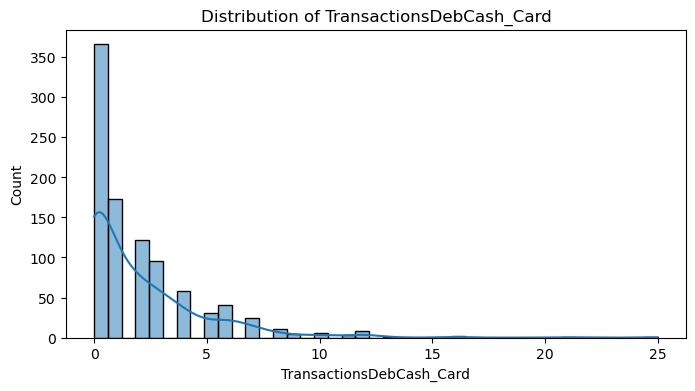

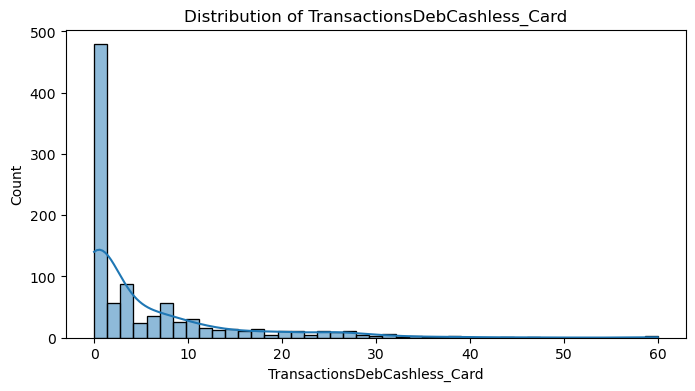

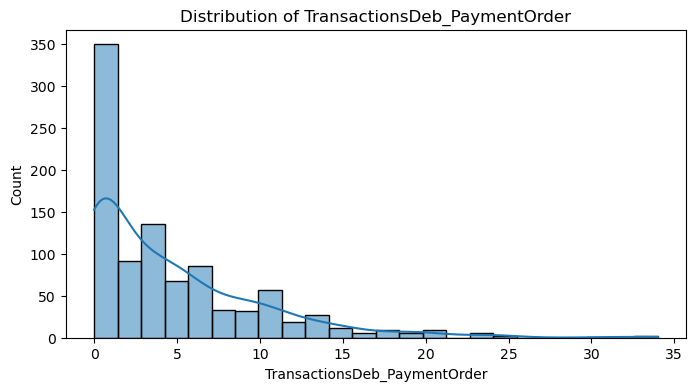

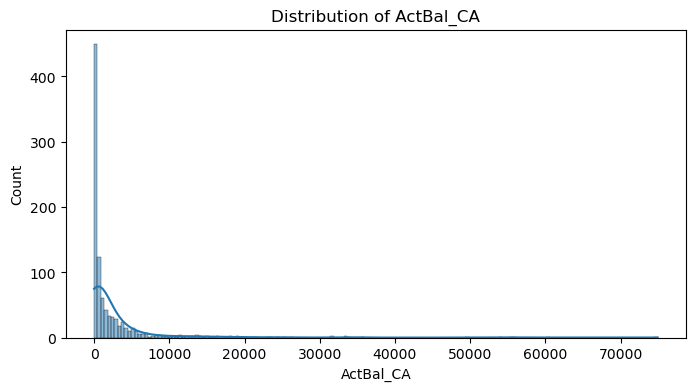

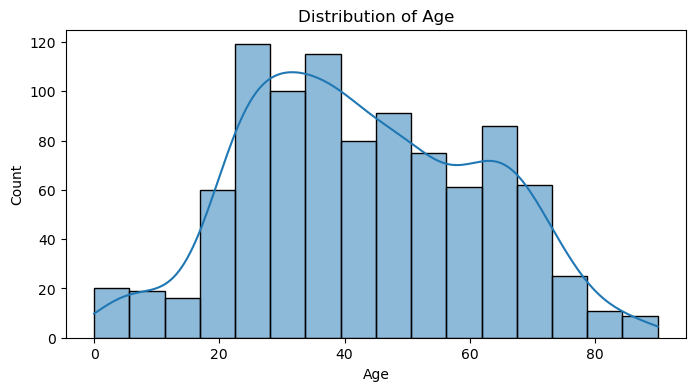

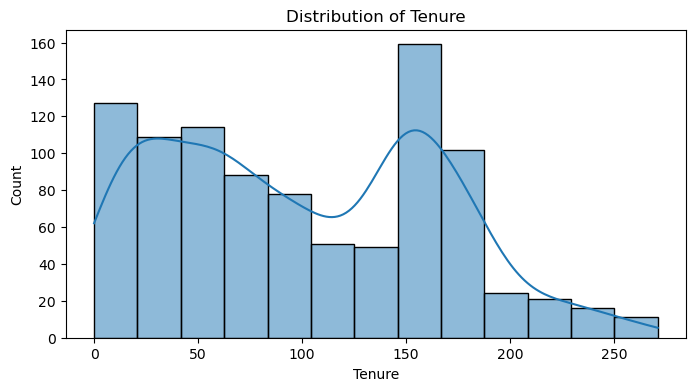

{'VolumeCred': (1833.1027374680111, 6214.772929146802), 'TransactionsCred': (5.654373024236038, 6.40819371040574), 'VolumeDebCash_Card': (271.08805735360534, 874.0443763706079), 'VolumeDebCashless_Card': (157.2512562095439, 333.1263888130185), 'VolumeDeb_PaymentOrder': (718.8769659792263, 3099.5234145039576), 'TransactionsDeb': (16.35721812434141, 16.375014476649568), 'TransactionsDebCash_Card': (2.0221285563751317, 2.7101913775150113), 'TransactionsDebCashless_Card': (5.360379346680716, 8.380238576055406), 'TransactionsDeb_PaymentOrder': (4.6206533192834565, 5.234786295593071), 'ActBal_CA': (2501.2710782026193, 6287.688907252993), 'Age': (42.92834562697576, 18.638005957513876), 'Tenure': (100.30558482613277, 65.65594600600575)}
         VolumeCred  TransactionsCred  VolumeDebCash_Card  \
count  10000.000000      10000.000000        10000.000000   
mean    3672.192911          7.962300          693.024726   
std     4108.672096          6.403544          614.268138   
min        0.0000

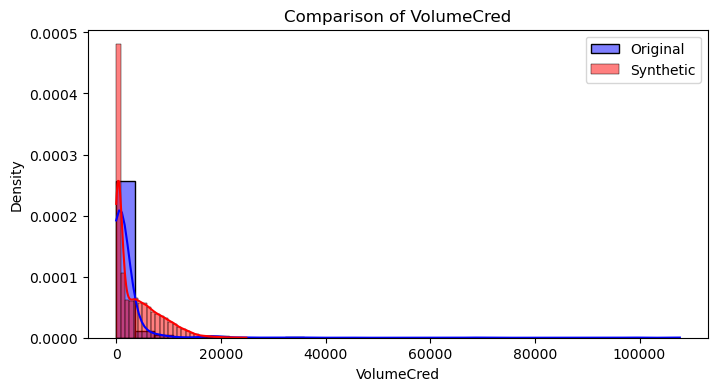

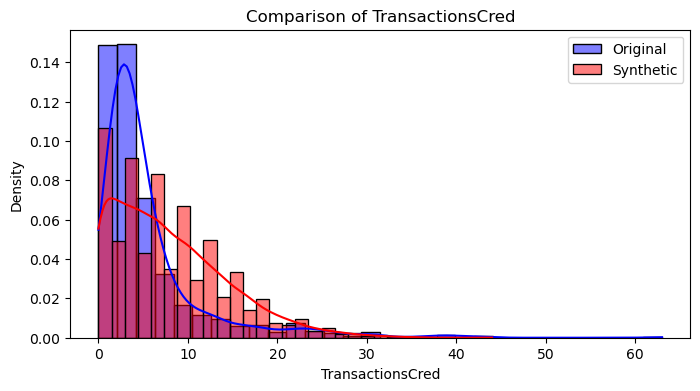

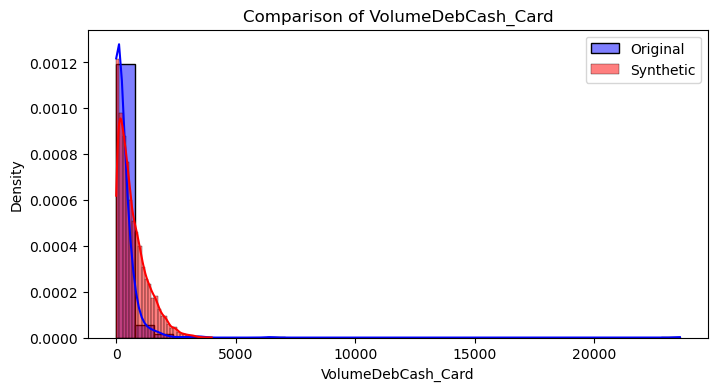

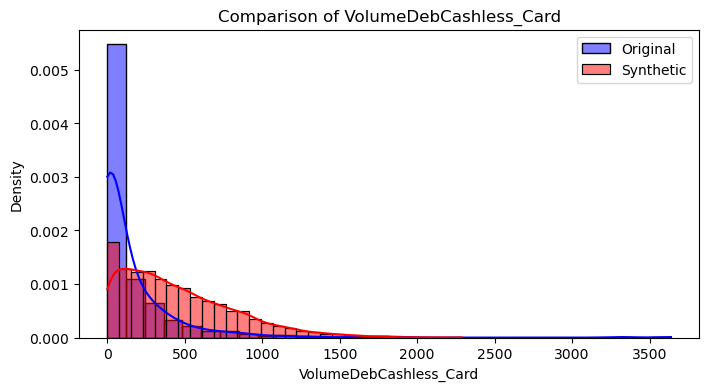

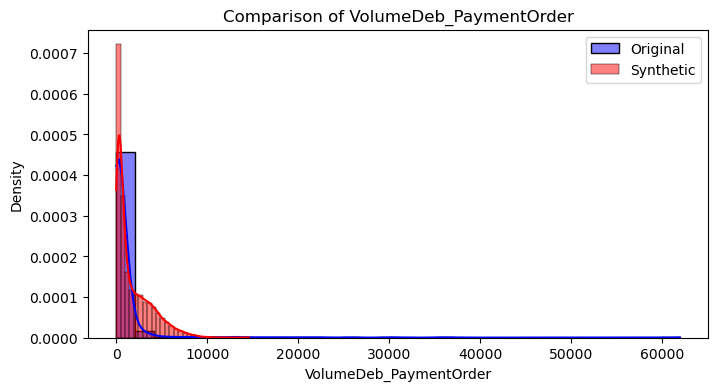

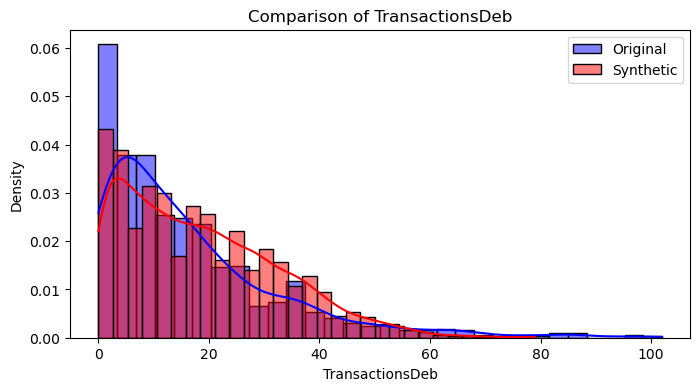

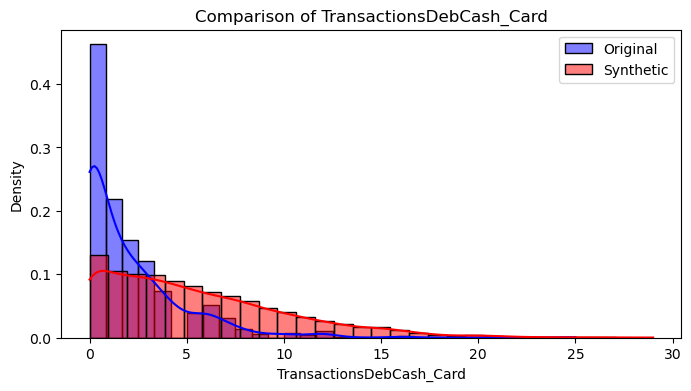

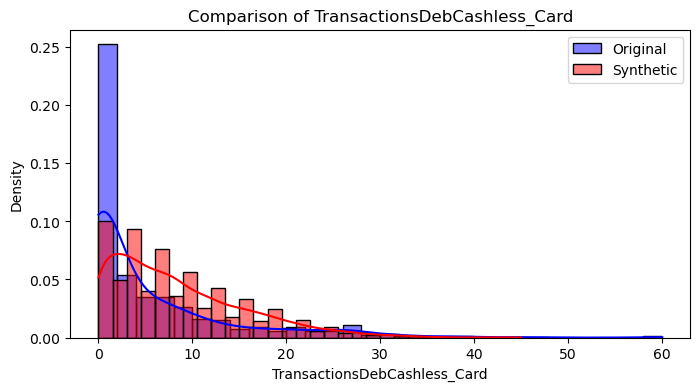

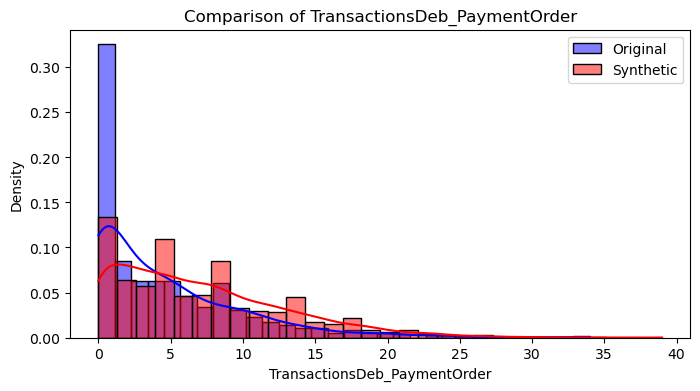

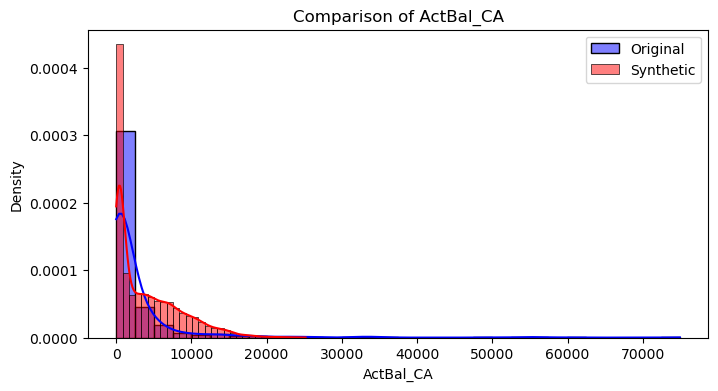

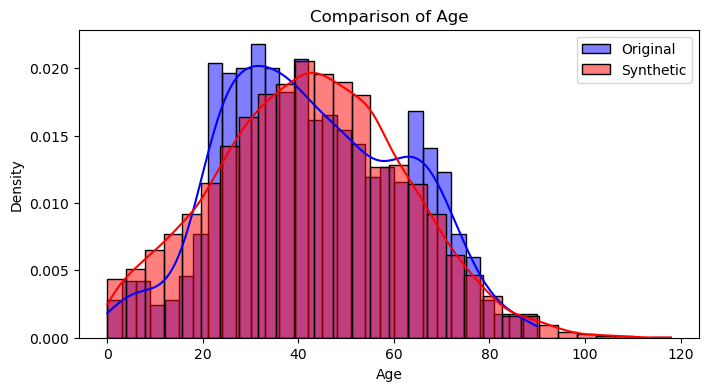

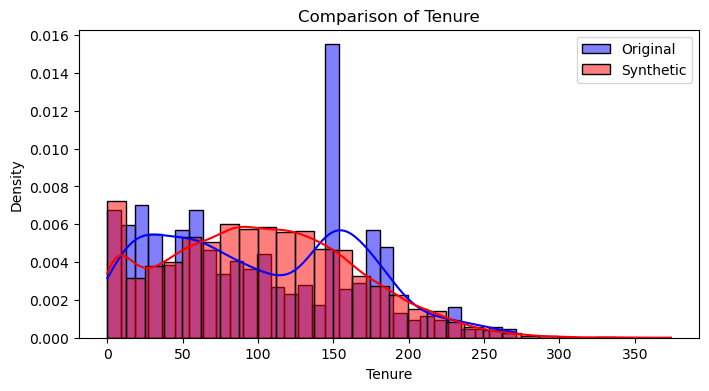

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from mesa import Agent, Model
from mesa.time import RandomActivation


# Summary statistics
print(df.describe())
print(df['Sex'].value_counts())

# Visualize distributions
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Fit distributions and store parameters
distributions = {}
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mu, std = stats.norm.fit(df[column])
    distributions[column] = (mu, std)

print(distributions)

# Define CustomerAgent class
class CustomerAgent(Agent):
    def __init__(self, unique_id, model, distributions):
        super().__init__(unique_id, model)
        self.attributes = {}
        for attribute, (mu, std) in distributions.items():
            if 'Transactions' in attribute or 'Count' in attribute or 'Age' in attribute or 'Tenure' in attribute:
                # For integer attributes, round the value to the nearest integer
                self.attributes[attribute] = max(int(np.random.normal(mu, std)), 0)
            else:
                # For float attributes, use the value as is
                self.attributes[attribute] = max(np.random.normal(mu, std), 0)
        self.attributes['Sex'] = np.random.choice(df['Sex'].unique(), p=[df['Sex'].value_counts(normalize=True)[s] for s in df['Sex'].unique()])
        self.attributes['Sale_MF'] = np.random.choice(df['Sale_MF'].unique(), p=[df['Sale_MF'].value_counts(normalize=True)[s] for s in df['Sale_MF'].unique()])
        self.attributes['Sale_CC'] = np.random.choice(df['Sale_CC'].unique(), p=[df['Sale_CC'].value_counts(normalize=True)[s] for s in df['Sale_CC'].unique()])
        self.attributes['Sale_CL'] = np.random.choice(df['Sale_CL'].unique(), p=[df['Sale_CL'].value_counts(normalize=True)[s] for s in df['Sale_CL'].unique()])


    def step(self):
        # Example behavior: modify attributes slightly to simulate change over time
        for attribute, (mu, std) in distributions.items():
            if 'Transactions' in attribute or 'Count' in attribute or 'Age' in attribute or 'Tenure' in attribute:
                # Update integer attributes
                self.attributes[attribute] = max(self.attributes[attribute] + int(np.random.normal(0, 1)), 0)
            else:
                # Update float attributes
                self.attributes[attribute] = max(self.attributes[attribute] + np.random.normal(0, 50), 0)

# Define the BankModel class
class BankModel(Model):
    def __init__(self, num_customers, distributions):
        self.num_agents = num_customers
        self.schedule = RandomActivation(self)

        for i in range(self.num_agents):
            a = CustomerAgent(i, self, distributions)
            self.schedule.add(a)

    def step(self):
        self.schedule.step()

# Run the model
num_customers = 10000  # Number of customers to simulate
num_steps = 100  # Number of simulation steps

model = BankModel(num_customers, distributions)

for i in range(num_steps):
    model.step()

# Collect the synthetic data
synthetic_df = pd.DataFrame([agent.attributes for agent in model.schedule.agents])

# Display synthetic data summary
print(synthetic_df.describe())


# Comparison with original data
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True, color='blue', label='Original', stat='density', bins=30)
    sns.histplot(synthetic_df[column], kde=True, color='red', label='Synthetic', stat='density', bins=30)
    plt.title(f'Comparison of {column}')
    plt.legend()
    plt.show()




In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, 0 to 950
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VolumeCred                    949 non-null    float64
 1   TransactionsCred              949 non-null    int64  
 2   VolumeDebCash_Card            949 non-null    float64
 3   VolumeDebCashless_Card        949 non-null    float64
 4   VolumeDeb_PaymentOrder        949 non-null    float64
 5   TransactionsDeb               949 non-null    int64  
 6   TransactionsDebCash_Card      949 non-null    int64  
 7   TransactionsDebCashless_Card  949 non-null    int64  
 8   TransactionsDeb_PaymentOrder  949 non-null    int64  
 9   ActBal_CA                     949 non-null    float64
 10  Sex                           949 non-null    object 
 11  Age                           949 non-null    int64  
 12  Tenure                        949 non-null    int64  
 13  Sale_MF   

In [7]:
synthetic_df.describe()

,VolumeCred,TransactionsCred,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,ActBal_CA,Age,Tenure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3672.192911,7.962300,693.024726,452.558463,1785.243099,18.566600,5.424300,8.463100,7.127000,4066.498562,42.453900,101.529500
std,4108.672096,6.403544,614.268138,361.315267,1965.538353,14.179847,4.608491,7.109367,5.831713,4346.679985,19.473623,61.789149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,390.726904,3.000000,220.672508,163.988372,314.836188,7.000000,2.000000,3.000000,2.000000,432.053289,29.000000,54.000000
50%,1839.406081,7.000000,518.855585,374.732497,890.669611,16.000000,4.000000,7.000000,6.000000,2556.353689,42.000000,99.000000
75%,6057.597577,12.000000,1004.101288,665.937914,2847.147885,28.000000,8.000000,12.000000,11.000000,6726.321304,56.000000,144.000000
max,24866.315904,44.000000,3992.218254,2288.250968,14585.528931,79.000000,29.000000,45.000000,39.000000,25176.657080,118.000000,374.000000


In [8]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VolumeCred                    10000 non-null  float64
 1   TransactionsCred              10000 non-null  int64  
 2   VolumeDebCash_Card            10000 non-null  float64
 3   VolumeDebCashless_Card        10000 non-null  float64
 4   VolumeDeb_PaymentOrder        10000 non-null  float64
 5   TransactionsDeb               10000 non-null  int64  
 6   TransactionsDebCash_Card      10000 non-null  int64  
 7   TransactionsDebCashless_Card  10000 non-null  int64  
 8   TransactionsDeb_PaymentOrder  10000 non-null  int64  
 9   ActBal_CA                     10000 non-null  float64
 10  Age                           10000 non-null  int64  
 11  Tenure                        10000 non-null  int64  
 12  Sex                           10000 non-null  object 
 13  Sa

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import seaborn as sns



synthetic_df['Sex'] = LabelEncoder().fit_transform(synthetic_df['Sex'])
synthetic_df['Sale_MF'] = LabelEncoder().fit_transform(synthetic_df['Sale_MF'])
synthetic_df['Sale_CL'] = LabelEncoder().fit_transform(synthetic_df['Sale_CL'])
synthetic_df['Sale_CC'] = LabelEncoder().fit_transform(synthetic_df['Sale_CC'])

synthetic_df.describe()


,VolumeCred,TransactionsCred,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,ActBal_CA,Age,Tenure,Sex,Sale_MF,Sale_CC,Sale_CL
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3672.192911,7.962300,693.024726,452.558463,1785.243099,18.566600,5.424300,8.463100,7.127000,4066.498562,42.453900,101.529500,0.537900,0.203800,0.249200,0.308200
std,4108.672096,6.403544,614.268138,361.315267,1965.538353,14.179847,4.608491,7.109367,5.831713,4346.679985,19.473623,61.789149,0.498586,0.402842,0.432571,0.461773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,390.726904,3.000000,220.672508,163.988372,314.836188,7.000000,2.000000,3.000000,2.000000,432.053289,29.000000,54.000000,0.000000,0.000000,0.000000,0.000000
50%,1839.406081,7.000000,518.855585,374.732497,890.669611,16.000000,4.000000,7.000000,6.000000,2556.353689,42.000000,99.000000,1.000000,0.000000,0.000000,0.000000
75%,6057.597577,12.000000,1004.101288,665.937914,2847.147885,28.000000,8.000000,12.000000,11.000000,6726.321304,56.000000,144.000000,1.000000,0.000000,0.000000,1.000000
max,24866.315904,44.000000,3992.218254,2288.250968,14585.528931,79.000000,29.000000,45.000000,39.000000,25176.657080,118.000000,374.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
X = synthetic_df.drop(columns=['Sale_MF', 'Sale_CC', 'Sale_CL'])
y = synthetic_df[['Sale_MF', 'Sale_CC', 'Sale_CL']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [11]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the logistic regression model
logreg = LogisticRegression(random_state=42)

# Train the model
multioutput_model = MultiOutputClassifier(logreg)
multioutput_model.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Predict on test data
y_pred = multioutput_model.predict(X_test_scaled)

# Evaluate accuracy for each target
for i, target in enumerate(['Sale_MF', 'Sale_CC', 'Sale_CL']):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {target}: {accuracy}")
    print(f"Classification report for {target}:\n {classification_report(y_test.iloc[:, i], y_pred[:, i])}")

# Calculate ROC AUC for each target
for i, target in enumerate(['Sale_MF', 'Sale_CC', 'Sale_CL']):
    probas = multioutput_model.predict_proba(X_test_scaled)[i][:, 1]
    auc = roc_auc_score(y_test.iloc[:, i], probas)
    print(f"ROC AUC for {target}: {auc}")

Accuracy for Sale_MF: 0.7906666666666666
Classification report for Sale_MF:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      2372
           1       0.00      0.00      0.00       628

    accuracy                           0.79      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.79      0.70      3000

Accuracy for Sale_CC: 0.7503333333333333
Classification report for Sale_CC:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86      2251
           1       0.00      0.00      0.00       749

    accuracy                           0.75      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.56      0.75      0.64      3000

Accuracy for Sale_CL: 0.6766666666666666
Classification report for Sale_CL:
               precision    recall  f1-score   support

           0       0.68      1.00      0.81      2030
      

In [12]:
df_real = pd.read_csv("synthetic_data_100_input.csv")

df_real['Sex'] = LabelEncoder().fit_transform(df_real['Sex'])

# Load the same scaler used for training
scaler = StandardScaler()
real_scaled = scaler.fit_transform(df_real)

In [13]:
predictions = multioutput_model.predict(real_scaled)
probabilities = multioutput_model.predict_proba(real_scaled)

# y_prob is a list of arrays; one array for each class
prob_MF = probabilities[0][:, 1].tolist()  # Probabilities for class 1
prob_CC = probabilities[1][:, 1].tolist()  # Probabilities for class 2
prob_CL = probabilities[2][:, 1].tolist()  # Probabilities for class 3



In [14]:
pred_MF = []
pred_CC = []
pred_CL = []


for i in range(100):
    pred_MF.append(predictions[i][0])
    pred_CC.append(predictions[i][1])
    pred_CL.append(predictions[i][2])
    


In [15]:
df_real['MF_pred'] = pred_MF
df_real['MF_prob'] = prob_MF
df_real['CC_pred'] = pred_CC
df_real['CC_prob'] = prob_CC
df_real['CL_pred'] = pred_CL
df_real['CL_prob'] = prob_CL

In [34]:
df_real.to_csv('synthetic_data_output.csv',index = False)